# 네이버 영화리뷰 감성분석 도전

## library import

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 데이터 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성
`data_loader()`
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

In [4]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [5]:
# tokenizer?

```python
>>> mecab = Mecab()
>>> print(mecab.morphs(u'영등포구청역에 있는 맛집 좀 알려주세요.'))
['영등포구', '청역', '에', '있', '는', '맛집', '좀', '알려', '주', '세요', '.']
>>> print(mecab.nouns(u'우리나라에는 무릎 치료를 잘하는 정형외과가 없는가!'))
['우리', '나라', '무릎', '치료', '정형외과']
>>> print(mecab.pos(u'자연주의 쇼핑몰은 어떤 곳인가?'))
[('자연', 'NNG'), ('주', 'NNG'), ('의', 'JKG'), ('쇼핑몰', 'NNG'), ('은', 'JX'), ('어떤', 'MM'), ('곳', 'NNG'), ('인가', 'VCP+EF'), ('?', 'SF')]
```

In [6]:
# 토큰화, 불용어 처리 함수. 
def get_tokens_no_stopwords(df):
    data = []
    for sentence in df:
        # 토큰화
        tokenized_sequences = tokenizer.morphs(sentence)
        # 불용어 제거
        tokens_no_stopwords = [token for token in tokenized_sequences if token not in stopwords]
        data.append(tokens_no_stopwords)
    return data

In [7]:
def load_data(train_data_df, test_data_df, num_words=10000):
    # [[YOUR CODE]]
    
    # 중복 제거
    train_data_df.drop_duplicates(inplace=True)
    test_data_df.drop_duplicates(inplace=True)
    
    # 결측치 제거
    train_data_df.dropna(inplace=True)
    test_data_df.dropna(inplace=True)

    # 처음 시도한 코드 -> 잘못됨; tokenizer.morphs는 문장을 input으로 받음
    # train_data =tokenizer.morphs(train_data['document'])
    # test_data = tokenizer.morphs(test_date['document']
    
    # 토큰화 & 불용어 제거
    X_train = get_tokens_no_stopwords(train_data_df['document'])
    
    # test 데이터에 대해서도 토큰화 & 불용어 제거
    X_test = get_tokens_no_stopwords(test_data_df['document'])    
    
    # word_to_index    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [8]:
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
index_to_word[0]

'<PAD>'

In [11]:
index_to_word[5]

'영화'

In [12]:
len(index_to_word)

10000

In [13]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [14]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.65940637625505
문장길이 최대 :  116
문장길이 표준편차 :  12.859527414389605


In [15]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

pad_sequences maxlen :  41
전체 문장의 0.9358074322972919%가 maxlen 설정값 이내에 포함됩니다. 


In [16]:
import tensorflow as tf

In [17]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(149995, 41)


In [18]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  32,  74, 921,   4,   4,  39, 230,  20,
        33, 752], dtype=int32)

## 모델 구성, validation set 구성, 모델 훈련, 그래프 시각화

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

### validation set 구성

In [19]:
# 중복을 제거하여 총 데이터 149995의 20%를 validation set으로 구성한다.
print(len(X_train))
# print(len(X_train)*0.2)
val_len = int(len(X_train)*0.2)
print(val_len)

149995
29999


In [20]:
# validation set 29999건 분리

x_val = X_train[:val_len]
y_val = y_train[:val_len]

# validation set을 제외한 나머지 
partial_x_train = X_train[val_len:]  
partial_y_train = y_train[val_len:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(119996, 41)
(119996,)


### RNN

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "rnn_best_model.h5",
    monitor='val_loss',      
    save_best_only=True,     
    mode='min',              
    verbose=1
)

In [22]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.SimpleRNN(8))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 8)                 200       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,281
Trainable params: 160,281
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/20
235/235 [==============================] - 9s 34ms/step - loss: 0.5131 - accuracy: 0.7622 - val_loss: 0.3827 - val_accuracy: 0.8404

Epoch 00001: val_loss improved from inf to 0.38269, saving model to rnn_best_model.h5
Epoch 2/20
235/235 [==============================] - 8s 33ms/step - loss: 0.3446 - accuracy: 0.8571 - val_loss: 0.3530 - val_accuracy: 0.8479

Epoch 00002: val_loss improved from 0.38269 to 0.35305, saving model to rnn_best_model.h5
Epoch 3/20
235/235 [==============================] - 8s 33ms/step - loss: 0.3046 - accuracy: 0.8756 - val_loss: 0.3546 - val_accuracy: 0.8491

Epoch 00003: val_loss did not improve from 0.35305
Epoch 4/20
235/235 [==============================] - 8s 33ms/step - loss: 0.2791 - accuracy: 0.8889 - val_loss: 0.3733 - val_accuracy: 0.8408

Epoch 00004: val_loss did not improve from 0.35305
Epoch 5/20
235/235 [==============================] - 8s 33ms/step - loss: 0.2579 - accuracy: 0.8987 - val_loss: 0.3834 - val_accuracy: 0.8407

Ep

In [24]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)
history_dict = history.history

1563/1563 - 6s - loss: 0.7483 - accuracy: 0.7963
[0.7483496069908142, 0.7962877750396729]


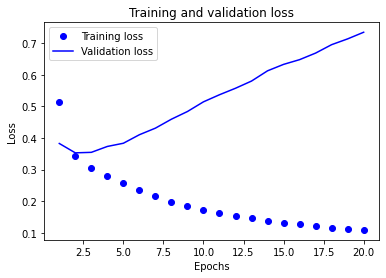

In [25]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

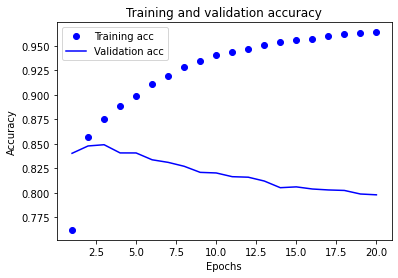

In [26]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

RNN으로 학습했을 때 2 epoch 이후 부터 과적합이 발생한 것을 확인할 수 있다.

In [27]:
from tensorflow.keras.models import load_model

best_model = load_model('rnn_best_model.h5')

result = best_model.evaluate(X_test, y_test, verbose=2)
print(result)

1563/1563 - 6s - loss: 0.3622 - accuracy: 0.8444
[0.36224302649497986, 0.8443706631660461]


체크포인트를 이용해서 최적 에폭에서 저장한 최고 모델에 대한 성능이 84.4% 정확도를 보여준다

#### 임베딩 레이어 저장작업

In [28]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [29]:
rnn_word2vec_file_path = "./word2vec/rnn_word2vec.txt"
f = open(rnn_word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

### LSTM

In [30]:
checkpoint = ModelCheckpoint(
    "lstm_best_model.h5",
    monitor='val_loss',      
    save_best_only=True,     
    mode='min',              
    verbose=1
)

In [31]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/20
235/235 [==============================] - 4s 7ms/step - loss: 0.5007 - accuracy: 0.7837 - val_loss: 0.3674 - val_accuracy: 0.8429

Epoch 00001: val_loss improved from inf to 0.36739, saving model to lstm_best_model.h5
Epoch 2/20
235/235 [==============================] - 1s 5ms/step - loss: 0.3409 - accuracy: 0.8581 - val_loss: 0.3435 - val_accuracy: 0.8517

Epoch 00002: val_loss improved from 0.36739 to 0.34351, saving model to lstm_best_model.h5
Epoch 3/20
235/235 [==============================] - 1s 5ms/step - loss: 0.3156 - accuracy: 0.8695 - val_loss: 0.3406 - val_accuracy: 0.8532

Epoch 00003: val_loss improved from 0.34351 to 0.34060, saving model to lstm_best_model.h5
Epoch 4/20
235/235 [==============================] - 1s 5ms/step - loss: 0.3021 - accuracy: 0.8746 - val_loss: 0.3488 - val_accuracy: 0.8511

Epoch 00004: val_loss did not improve from 0.34060
Epoch 5/20
235/235 [==============================] - 1s 5ms/step - loss: 0.2914 - accuracy: 0.8795 - val_lo

In [33]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)
history_dict = history.history

1563/1563 - 3s - loss: 0.4915 - accuracy: 0.8318
[0.4914546310901642, 0.831809937953949]


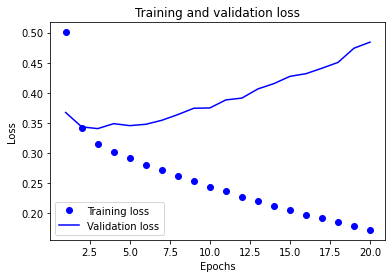

In [34]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

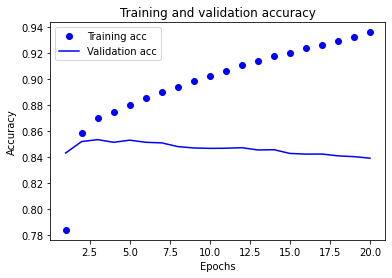

In [35]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

에폭 3 이후부터 과적합을 확인할 수 있다.

In [36]:
best_model = load_model('lstm_best_model.h5')

result = best_model.evaluate(X_test, y_test, verbose=2)
print(result)

1563/1563 - 3s - loss: 0.3526 - accuracy: 0.8474
[0.352599561214447, 0.8473508358001709]


최적 에폭 3에서의 베스트 모델의 정확도 84.7% 를 확인할 수 있다.  
RNN보다 0.4% 향상되었다

#### 임베딩 레이어 저장작업

In [37]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]

lstm_word2vec_file_path = "./word2vec/lstm_word2vec.txt"
f = open(lstm_word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

### Conv1D

In [38]:
checkpoint = ModelCheckpoint(
    "conv1d_best_model.h5",
    monitor='val_loss',      
    save_best_only=True,     
    mode='min',              
    verbose=1
)

In [39]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [40]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/20
235/235 [==============================] - 3s 6ms/step - loss: 0.5009 - accuracy: 0.7393 - val_loss: 0.3504 - val_accuracy: 0.8473

Epoch 00001: val_loss improved from inf to 0.35044, saving model to conv1d_best_model.h5
Epoch 2/20
235/235 [==============================] - 1s 5ms/step - loss: 0.3258 - accuracy: 0.8622 - val_loss: 0.3360 - val_accuracy: 0.8542

Epoch 00002: val_loss improved from 0.35044 to 0.33604, saving model to conv1d_best_model.h5
Epoch 3/20
235/235 [==============================] - 1s 5ms/step - loss: 0.2899 - accuracy: 0.8801 - val_loss: 0.3303 - val_accuracy: 0.8570

Epoch 00003: val_loss improved from 0.33604 to 0.33031, saving model to conv1d_best_model.h5
Epoch 4/20
235/235 [==============================] - 1s 5ms/step - loss: 0.2610 - accuracy: 0.8949 - val_loss: 0.3347 - val_accuracy: 0.8552

Epoch 00004: val_loss did not improve from 0.33031
Epoch 5/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2310 - accuracy: 0.9092 - 

In [41]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)
history_dict = history.history

1563/1563 - 2s - loss: 0.9150 - accuracy: 0.8181
[0.9149752259254456, 0.8181490898132324]


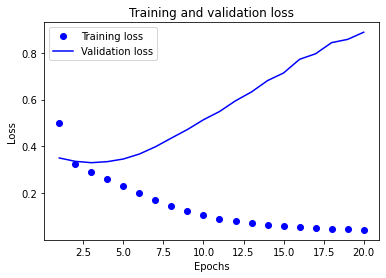

In [42]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

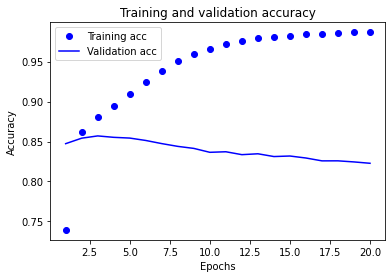

In [43]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

에폭 3 이후 과대적합이 발생한 것을 확인할 수 있다

In [44]:
best_model = load_model('conv1d_best_model.h5')

result = best_model.evaluate(X_test, y_test, verbose=2)
print(result)

1563/1563 - 3s - loss: 0.3475 - accuracy: 0.8523
[0.3475135564804077, 0.8522911667823792]


베스트모델은 85%의 정확도를 보여준다.  
RNN, LSTM 보다 조금 더 좋은 성능을 보여준다.

#### 임베딩 벡터 저장 작업

In [45]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]

conv1d_word2vec_file_path = "./word2vec/cov1d_word2vec.txt"
f = open(conv1d_word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

## Embedding 레이어 분석

#### RNN

In [46]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

rnn_word2vec = Word2VecKeyedVectors.load_word2vec_format(rnn_word2vec_file_path, binary=False)
rnn_vector = rnn_word2vec['영화']
rnn_vector

array([ 0.01945181,  0.03685273, -0.00098458,  0.00376592,  0.02360986,
       -0.02140371, -0.01315953,  0.01169386,  0.00133277, -0.00860339,
        0.02849657,  0.03773269, -0.02343207, -0.0126952 ,  0.01726513,
       -0.03953113], dtype=float32)

In [47]:
rnn_word2vec.similar_by_word("영화")

[('제목', 0.6646891832351685),
 ('선하', 0.6259468197822571),
 ('입니다', 0.594343364238739),
 ('재미난', 0.5902538895606995),
 ('아님', 0.579514741897583),
 ('니', 0.5747101902961731),
 ('^^^', 0.5738192200660706),
 ('비용', 0.571951687335968),
 ('후반부', 0.5526955127716064),
 ('남자', 0.5469887852668762)]

#### LSTM

In [48]:
lstm_word2vec = Word2VecKeyedVectors.load_word2vec_format(lstm_word2vec_file_path, binary=False)
lstm_vector = lstm_word2vec['영화']
lstm_vector

array([-0.10887628,  0.00977015, -0.06869444,  0.15151602, -0.04958283,
        0.08033824,  0.0400685 ,  0.04380161, -0.14042014,  0.00161021,
        0.0481138 , -0.00340191,  0.21454592,  0.0483597 ,  0.06839363,
        0.00802163], dtype=float32)

In [49]:
lstm_word2vec.similar_by_word('영화')

[('!!!', 0.8423011302947998),
 ('음', 0.8259586691856384),
 ('준다', 0.8242020010948181),
 ('공', 0.8152931332588196),
 ('.................', 0.8086978197097778),
 ('네요', 0.805845320224762),
 ('습니다', 0.7944600582122803),
 ('~~', 0.7898532748222351),
 ('점', 0.780249297618866),
 ('ㅎ', 0.7738766670227051)]

#### Cov1D

In [50]:
conv1d_word2vec_file_path = "./word2vec/cov1d_word2vec.txt"

In [51]:
conv1d_word2vec = Word2VecKeyedVectors.load_word2vec_format(conv1d_word2vec_file_path, binary=False)
conv1d_vector = conv1d_word2vec['영화']
conv1d_vector

array([ 0.07408932,  0.04713816,  0.02841508,  0.02714497, -0.02641444,
       -0.03938203, -0.04240947,  0.00812506,  0.06384771, -0.05487867,
        0.05894364,  0.03110279,  0.01811439, -0.0024302 ,  0.04680558,
        0.09064873], dtype=float32)

In [52]:
conv1d_word2vec.similar_by_word('영화')

[('아픕니다', 0.8521854877471924),
 ('안타깝', 0.8180021047592163),
 ('외면', 0.8096705675125122),
 ('떨어트리', 0.7986404299736023),
 ('나와라', 0.7873570322990417),
 ('킴', 0.7800331711769104),
 ('여행', 0.7796190977096558),
 ('신났', 0.7733162045478821),
 ('뒷맛', 0.770275890827179),
 ('니다', 0.7698658108711243)]

In [53]:
len(conv1d_word2vec)

9996

### 각 모델 비교


In [54]:
from pprint import pprint

In [55]:
print("rnn")
pprint(rnn_word2vec.similar_by_word("영화"))
print("lstm")
pprint(lstm_word2vec.similar_by_word('영화'))
print("conv1d")
pprint(conv1d_word2vec.similar_by_word('영화'))

rnn
[('제목', 0.6646891832351685),
 ('선하', 0.6259468197822571),
 ('입니다', 0.594343364238739),
 ('재미난', 0.5902538895606995),
 ('아님', 0.579514741897583),
 ('니', 0.5747101902961731),
 ('^^^', 0.5738192200660706),
 ('비용', 0.571951687335968),
 ('후반부', 0.5526955127716064),
 ('남자', 0.5469887852668762)]
lstm
[('!!!', 0.8423011302947998),
 ('음', 0.8259586691856384),
 ('준다', 0.8242020010948181),
 ('공', 0.8152931332588196),
 ('.................', 0.8086978197097778),
 ('네요', 0.805845320224762),
 ('습니다', 0.7944600582122803),
 ('~~', 0.7898532748222351),
 ('점', 0.780249297618866),
 ('ㅎ', 0.7738766670227051)]
conv1d
[('아픕니다', 0.8521854877471924),
 ('안타깝', 0.8180021047592163),
 ('외면', 0.8096705675125122),
 ('떨어트리', 0.7986404299736023),
 ('나와라', 0.7873570322990417),
 ('킴', 0.7800331711769104),
 ('여행', 0.7796190977096558),
 ('신났', 0.7733162045478821),
 ('뒷맛', 0.770275890827179),
 ('니다', 0.7698658108711243)]


In [56]:
print("rnn")
pprint(rnn_word2vec.similar_by_word("재미"))
print("lstm")
pprint(lstm_word2vec.similar_by_word('재미'))
print("conv1d")
pprint(conv1d_word2vec.similar_by_word('재미'))

rnn
[('성적', 0.7682225108146667),
 ('놀라운', 0.7658958435058594),
 ('소이현', 0.7239970564842224),
 ('되', 0.7158957123756409),
 ('전화', 0.7134594917297363),
 ('오빠', 0.7108316421508789),
 ('어울렸', 0.708785355091095),
 ('아메리카', 0.69810551404953),
 ('예뻐', 0.68907630443573),
 ('예쁜데', 0.6844303607940674)]
lstm
[('마약', 0.8527597784996033),
 ('졸라', 0.8232815265655518),
 ('매우', 0.7988520860671997),
 ('두', 0.7979480624198914),
 ('넘', 0.7956135272979736),
 ('물씬', 0.7895365953445435),
 ('엄정화', 0.7820769548416138),
 ('만약', 0.7735623121261597),
 ('되게', 0.7648885846138),
 ('렛', 0.7569904327392578)]
conv1d
[('실존', 0.8273065090179443),
 ('오르', 0.8233906030654907),
 ('달라', 0.7994505167007446),
 ('들어간', 0.7985733151435852),
 ('T', 0.7881333231925964),
 ('송', 0.7836806178092957),
 ('봐선', 0.7616115212440491),
 ('김강우', 0.7614694833755493),
 ('로선', 0.7610533237457275),
 ('냉전', 0.7568932175636292)]


In [57]:
print("rnn")
pprint(rnn_word2vec.similar_by_word("별로"))
print("lstm")
pprint(lstm_word2vec.similar_by_word('별로'))
print("conv1d")
pprint(conv1d_word2vec.similar_by_word('별로'))

rnn
[('순이', 0.963336169719696),
 ('족', 0.9458797574043274),
 ('심함', 0.9435860514640808),
 ('고리타분', 0.9426063299179077),
 ('드러워', 0.9422557950019836),
 ('맛없', 0.9405969977378845),
 ('거창', 0.9385854005813599),
 ('현저히', 0.9309677481651306),
 ('지겨워', 0.9299936890602112),
 ('이따위', 0.9262809753417969)]
lstm
[('레기', 0.9790929555892944),
 ('뻔한', 0.9721353650093079),
 ('억지', 0.9710261225700378),
 ('내놔', 0.9695850014686584),
 ('개똥철학', 0.9688241481781006),
 ('평이', 0.9684625267982483),
 ('빨', 0.9660613536834717),
 ('OUT', 0.9649643301963806),
 ('혈압', 0.9640105366706848),
 ('구림', 0.9618957042694092)]
conv1d
[('유루', 0.8700574040412903),
 ('도통', 0.8413075804710388),
 ('졸립', 0.8336706161499023),
 ('멘스', 0.8334320187568665),
 ('센터', 0.8312356472015381),
 ('기능', 0.8265584111213684),
 ('얼렁뚱땅', 0.8232229948043823),
 ('유치뽕', 0.8221406936645508),
 ('꺼버렸', 0.8219468593597412),
 ('싱겁', 0.8219088315963745)]


각 모델로 학습한 임베딩 벡터에 대해서 영화에 대한 유사한 단어들이 다르게 표현되는 것을 확인할 수 있다.  

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [58]:
!ls /aiffel/data/word2vec*

/aiffel/data/word2vec_ko.model
/aiffel/data/word2vec_ko.model.trainables.syn1neg.npy
/aiffel/data/word2vec_ko.model.wv.vectors.npy


In [59]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = "/aiffel/data/word2vec_ko.model"
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv["영화"]

In [60]:
vector

array([-1.8007389 , -1.1790098 , -2.4066596 ,  2.1384156 , -0.3537603 ,
        1.3749527 , -4.894612  , -3.6517198 ,  0.4411444 ,  0.78153926,
       -2.696888  , -1.7812852 , -2.1514654 , -4.813236  ,  2.7465918 ,
       -2.1620324 , -0.11467794, -1.2431171 ,  2.3979309 , -1.1060628 ,
       -0.41043055,  1.9500391 ,  0.7821002 ,  1.5899978 ,  1.6447444 ,
       -2.1265035 , -1.7981595 ,  1.7535795 ,  0.53717697, -1.212121  ,
       -4.466316  ,  4.5488324 ,  1.334441  , -0.9070271 ,  1.1931889 ,
        4.1563215 ,  1.9758307 , -0.9437562 , -0.2592725 ,  0.34935686,
        1.8562875 , -3.3249645 ,  1.1221625 ,  1.2836524 ,  3.9211376 ,
        3.8023994 ,  2.766269  ,  0.67293745,  2.2853644 , -5.1131716 ,
        0.32525915, -3.3079958 ,  5.3043513 , -3.8813758 , -0.32960036,
       -1.9527504 ,  3.8865075 , -3.5470378 , -0.21991685,  0.82119733,
       -0.9492492 ,  3.5472107 ,  1.322048  , -0.70640826,  0.52253807,
        1.4683235 , -1.1018689 ,  2.262941  , -0.7204685 , -1.76

In [61]:
word_vectors.wv.similar_by_word("영화")

[('드라마', 0.8418774008750916),
 ('뮤지컬', 0.7775140404701233),
 ('코미디', 0.7489107251167297),
 ('다큐멘터리', 0.7401294708251953),
 ('헐리우드', 0.7397844195365906),
 ('애니메이션', 0.7170552015304565),
 ('독립영화', 0.7113528251647949),
 ('로맨틱', 0.7107657194137573),
 ('장편', 0.7101576924324036),
 ('극영화', 0.7045413255691528)]

In [62]:
word_vectors.wv.similar_by_word("재미")

[('묘미', 0.6163142919540405),
 ('취미', 0.6034970283508301),
 ('흥미', 0.5939850211143494),
 ('유머', 0.5888698101043701),
 ('보람', 0.5689517259597778),
 ('즐거움', 0.5631207823753357),
 ('개그', 0.5552946329116821),
 ('이야기', 0.5536993741989136),
 ('연애', 0.552293598651886),
 ('열의', 0.546456515789032)]

In [63]:
word_vectors.wv.similar_by_word("별로")

[('전혀', 0.6421527862548828),
 ('그다지', 0.6234328746795654),
 ('꽤', 0.6035930514335632),
 ('확실히', 0.5738269090652466),
 ('딱히', 0.5515185594558716),
 ('상당히', 0.542231023311615),
 ('볼일', 0.5412046313285828),
 ('다름', 0.531372606754303),
 ('별', 0.5228564739227295),
 ('확연히', 0.5193501710891724)]

pretrained 모델은 단어에 대해 한국어 사전과 같은 동의어를 유사한 단어 벡터로 확인할 수 있다.

In [64]:
len(vector)

100

In [65]:
len(word_vectors.wv)

302960

#### pretrained word2vec + conv1d

In [68]:
vocab_size = 10000    # 어휘 사전의 크기입니다
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [69]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [70]:
checkpoint = ModelCheckpoint(
    "pretrained_best_model.h5",
    monitor='val_loss',      
    save_best_only=True,     
    mode='min',              
    verbose=1
)

In [71]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/20
235/235 [==============================] - 3s 6ms/step - loss: 0.6185 - accuracy: 0.6426 - val_loss: 0.5015 - val_accuracy: 0.7577

Epoch 00001: val_loss improved from inf to 0.50147, saving model to pretrained_best_model.h5
Epoch 2/20
235/235 [==============================] - 1s 5ms/step - loss: 0.4550 - accuracy: 0.7883 - val_loss: 0.4231 - val_accuracy: 0.8077

Epoch 00002: val_loss improved from 0.50147 to 0.42306, saving model to pretrained_best_model.h5
Epoch 3/20
235/235 [==============================] - 1s 5ms/step - loss: 0.3901 - accuracy: 0.8261 - val_loss: 0.3892 - val_accuracy: 0.8259

Epoch 00003: val_loss improved from 0.42306 to 0.38915, saving model to pretrained_best_model.h5
Epoch 4/20
235/235 [==============================] - 1s 5ms/step - loss: 0.3511 - accuracy: 0.8469 - val_loss: 0.3689 - val_accuracy: 0.8371

Epoch 00004: val_loss improved from 0.38915 to 0.36895, saving model to pretrained_best_model.h5
Epoch 5/20
235/235 [========================

In [72]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)
history_dict = history.history

1563/1563 - 2s - loss: 0.5176 - accuracy: 0.8330
[0.5175846219062805, 0.8330299854278564]


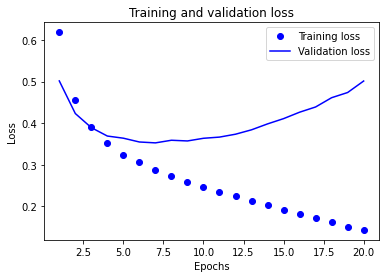

In [73]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

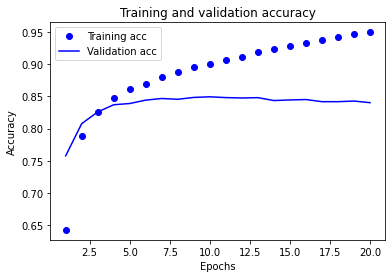

In [74]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

7 에폭 이후 과대적합이 발생했다.

In [77]:
best_model = load_model('pretrained_best_model.h5')

result = best_model.evaluate(X_test, y_test, verbose=2)
print(result)

1563/1563 - 3s - loss: 0.3687 - accuracy: 0.8411
[0.36866816878318787, 0.8410504460334778]


네이버 영화 리뷰 데이터와 conv1d로만 학습했을 때, 85% 정확도를 보였었는데,  
pretrained 벡터를 활용하여 84.1%로 오히려 성능이 조금 떨어진 것을 확인했다.

#### pretrained word2vec + LSTM

In [78]:
checkpoint = ModelCheckpoint(
    "pretrained_lstm_best_model.h5",
    monitor='val_loss',      
    save_best_only=True,     
    mode='min',              
    verbose=1
)

In [79]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/20
235/235 [==============================] - 3s 7ms/step - loss: 0.5941 - accuracy: 0.6753 - val_loss: 0.4735 - val_accuracy: 0.7798

Epoch 00001: val_loss improved from inf to 0.47352, saving model to pretrained_lstm_best_model.h5
Epoch 2/20
235/235 [==============================] - 1s 6ms/step - loss: 0.4255 - accuracy: 0.8086 - val_loss: 0.3944 - val_accuracy: 0.8229

Epoch 00002: val_loss improved from 0.47352 to 0.39437, saving model to pretrained_lstm_best_model.h5
Epoch 3/20
235/235 [==============================] - 1s 6ms/step - loss: 0.3705 - accuracy: 0.8382 - val_loss: 0.3708 - val_accuracy: 0.8380

Epoch 00003: val_loss improved from 0.39437 to 0.37083, saving model to pretrained_lstm_best_model.h5
Epoch 4/20
235/235 [==============================] - 1s 6ms/step - loss: 0.3417 - accuracy: 0.8532 - val_loss: 0.3621 - val_accuracy: 0.8413

Epoch 00004: val_loss improved from 0.37083 to 0.36208, saving model to pretrained_lstm_best_model.h5
Epoch 5/20
235/235 [====

In [81]:
best_model = load_model('pretrained_lstm_best_model.h5')

result = best_model.evaluate(X_test, y_test, verbose=2)
print(result)

1563/1563 - 3s - loss: 0.3637 - accuracy: 0.8424
[0.36373448371887207, 0.8423905372619629]


pretrained word2vec를 사용한 LSTM 모델도 성능이 조글 하락하였다.

# 회고

RNN, LSTM, Conv1D에서 임베딩 벡터들이 차이나는 이유에 대해서 생각해 볼 수 있었다.     
Conv1D에서는 필터사이즈가 7이기 때문에, 단어 주위 7단어 사이의 관계만 학습하는 것 같다.  
LSTM과 RNN의 비교에서는 LSTM이 RNN보다 이전 state에 대한 영향을 크게 가지는 구조여서, 이런 구조의 차이가 벡터의 차이를 만들어 내는 것 같다.  
   
pretrained 모델을 사용한 임베딩 벡터와 영화 리뷰를 학습한 모델들의 임베딩 벡터의 비교해서 생각해 볼 수 있었다.  pretrained 모델의 단어 벡터의 유사한 단어들을 확인했을 때, 한국어 사전의 동의어와 같은 유사한 단어들을 나타내는데, pretrained 모델이 학습 데이터가 일상생활 데이터이고, 문서 전체적인 범위에서 단어 사이의 관게를 학습해서인 것 같다.  
위의 모델들이 학습하는 구조에서는 단어 사이 관계의 범위가 sequence를 벗어나지 못하는 데, 이런 모델 학습의 구조가, 벡터의 차이를 보이는 것 같다. 

pretrained word2vec이 영화리뷰에 대한 도메인 정보를 잘 반영하지 못하는 것 같다. 
그래서 pretrained word2vec을 사용한 모델들이 더 성능이 낮게 나오는 것을 확인했다.  